In [1]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from torch_geometric.utils import to_networkx, to_dense_adj
from torch_geometric.loader import DataLoader
import sys
sys.path.append('../')

from spikeometric.models import BernoulliGLM
from spikeometric.stimulus import RegularStimulus, LoadedStimulus
from spikeometric.datasets import NormalGenerator, ConnectivityDataset

In [2]:
# Set parameters for simulation
n_neurons = 100
n_networks = 10
n_steps = 10000
rng = torch.Generator().manual_seed(14071789)

## Stimulating networks with an external input
A very common use of GLM and LNP models is as stimulus-response models. We stimulate the network with some external input and record and analyze the results.
In this example we'll show how the package can help you with this workflow.

### Loading a set of networks
We first want to generate a connectivity dataset of 10 networks, each with 100 neurons.
The networks have ~5000 edges (half dense) and the synaptic weights are drawn from a normal distribution with mean $0$ and standard deviation $5 / \sqrt{100}$ (glorot initialization). The connectivity matrices are saved together in a directory.

In [3]:
NormalGenerator(n_neurons=n_neurons, mean=0, std=5, glorot=True).save(n_networks, f'data/w0/{n_neurons}_neurons_{n_networks}_networks_0_5_glorot/')

We can then load them using the `ConnectivityDataset` class.

In [4]:
# Load the network and add self-loops to the connectivity matrix. This is necessary for the refractory period to work.
dataset = ConnectivityDataset("data/w0/100_neurons_10_networks_0_5_glorot")

Before we continue we can use vizualization tools from networkx to get an idea of what our networks look like. 

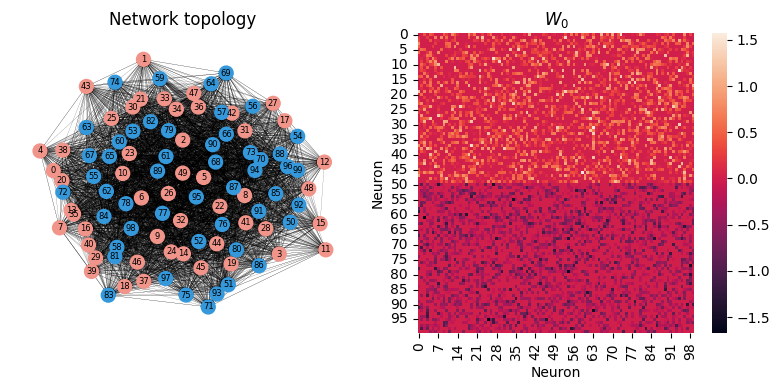

In [5]:
example_network = dataset[0]
G = to_networkx(example_network, remove_self_loops=True)
color_map = ["#f1948a" for _ in range(n_neurons//2)] + ["#3498db" for _ in range(n_neurons//2, n_neurons)] # Red for excitatory, blue for inhibitory

# Visualize the network
fig, ax = plt.subplots(1, 2, figsize=(8, 4))

nx.draw(G, node_size=100, node_color=color_map, width=0.1, arrowsize=1, with_labels=True, font_size=6, ax=ax[0])
ax[0].set_title("Network topology")

square_W0 = to_dense_adj(example_network.edge_index, edge_attr=example_network.W0, max_num_nodes=n_neurons)[0]
sns.heatmap(square_W0, ax=ax[1])
ax[1].set_title(r"$W_0$")
ax[1].set_xlabel("Neuron")
ax[1].set_ylabel("Neuron")

plt.tight_layout()
plt.show()

The network seems to be randomly connected in one big cluster. From the heatplot we see that the first half of the neurons are excitatory and the second half inhibitory

### Initializing the model
The next step is to define the model that we want to use. For this example we will use the Bernoulli GLM model, which is implemented
in the `BernoulliGLM` class, using the same parameters as in the original paper 
["Inferring causal connectivity from pairwise recordings and optogenetics"](https://www.biorxiv.org/content/10.1101/463760v3.full).

In [6]:
model = BernoulliGLM(
    alpha= 0.2,               # Decay rate of the coupling strength between neurons (1/ms)
    beta= 0.5,                # Decay rate of the self-inhibition during the relative refractory period (1/ms)
    abs_ref_scale=3,          # Absolute refractory period (ms)
    rel_ref_scale=7,          # Relative refractory period (ms)
    abs_ref_strength=-100,    # Strength of the self-inhibition during the absolute refractory period
    rel_ref_strength=-30,     # Initial strength of the self-inhibition during the relative refractory period
    coupling_window=5,        # Length of coupling window (ms)
    theta=5,                  # Threshold for firing
    dt=1,                     # Length of time step (ms)
)

### Stimulus
We will use the `RegularStimulus` class to give a short stimulus at 100 ms intervals,
lasting for $\tau=10$ ms each time. The strength of the stimulus will be $5$, which given the threshold parameter $\theta=5$ of the model, will result in a ~$50$% chance of firing for a neuron at rest. Keep in mind that we need to make sure the length of the stimulus mask we pass here is the same as the number of neurons in each batch.

In [7]:
stim_mask = torch.arange(1000) % 100 < 10
stimulus = RegularStimulus(strength=1, period=100, tau=10, stop=10000, stimulus_masks=stim_mask)
model.add_stimulus(stimulus)

### Simulation
To simulate the networks, we pass the dataset to the DataLoader and iterate over it to get batches of ten networks at a time.

In [8]:
data_loader = DataLoader(dataset, batch_size=10, shuffle=False)

results = torch.zeros(n_neurons*n_networks, n_steps)
for i, batch in enumerate(data_loader):
     results[i*batch.num_nodes:(i+1)*batch.num_nodes] = model.simulate(batch, n_steps=n_steps)

100%|██████████| 10000/10000 [00:07<00:00, 1362.14it/s]


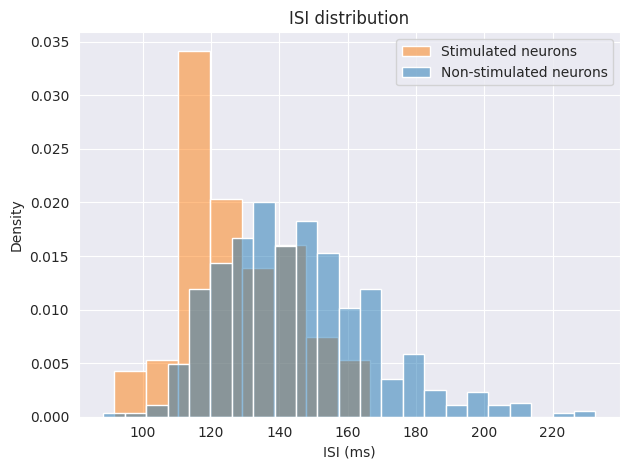

In [9]:
# Compare the firing rates of the stimulated neurons to the firing rates of the non-stimulated neurons
sns.set_style("darkgrid")

isi = 1 / (results.mean(dim=1))
isi_stimulated = isi[stim_mask]
isi_non_stimulated = isi[~stim_mask]

sns.histplot(isi_stimulated, label="Stimulated neurons", stat="density", color="C1", alpha=0.5)  
sns.histplot(isi_non_stimulated, label="Non-stimulated neurons", stat="density", color="C0", alpha=0.5)
plt.legend()
plt.title("ISI distribution")
plt.xlabel("ISI (ms)")
plt.ylabel("Density")

plt.tight_layout()
plt.savefig("../docs/_static/isi_distribution.png")

Let's take a look at the results. We will plot the raster plot for the first network over the first stimulus period, the interspike interval distribution and the peristimulus time histogram.

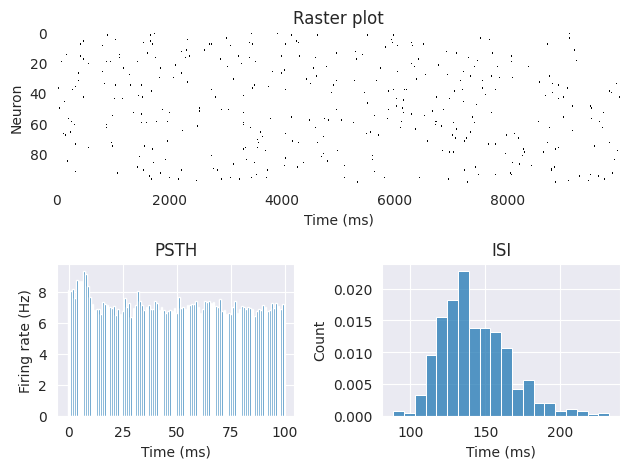

In [10]:
# PSTH
stim_period = 100
binned_results = results.reshape(results.shape[0], -1, stim_period).mean(axis=1) * 1000 # Wrap around the stimulus period

fig = plt.figure()
gs = fig.add_gridspec(2, 2)
ax0 = fig.add_subplot(gs[0, :])
ax1 = fig.add_subplot(gs[1, 0])
ax2 = fig.add_subplot(gs[1, 1])

ax0.imshow(results[:n_neurons], aspect="auto", cmap="binary", interpolation="none")
ax0.set_title("Raster plot")
ax0.set_xlabel("Time (ms)")
ax0.set_ylabel("Neuron")
# ax0.axvspan(0, 10, alpha=0.1, color="red")

ax1.bar(torch.arange(0, stim_period), binned_results.mean(axis=0))
ax1.set_title("PSTH")
ax1.set_xlabel("Time (ms)")
ax1.set_ylabel("Firing rate (Hz)")
# ax1.axvspan(0, 10, alpha=0.1, color="red")

isi = 1 / (results.mean(1))
sns.histplot(isi, ax=ax2, stat="density", bins=20)
ax2.set_title("ISI")
ax2.set_xlabel("Time (ms)")
ax2.set_ylabel("Count")


plt.tight_layout()
plt.show()

Instead of using one of the pre-defined stimulus classes, it is also possible to load a stimulus plan from a file using the `LoadedStimulus` class.

In [2]:
# Make a stimulus plan for stimulating 10 different neurons
# in 5 networks, each with 100 neurons over 10000 ms
stimulus = torch.zeros(100, 10000, 5) # (neuron, time step, network)
stimulus[torch.randint(0, 100, (10,))] = torch.randn(10, 10000, 5) # Stimulate 10 random neurons in each network

# Save to a torch file
torch.save(stimulus, "data/saved_stimulus.pt")

# Load the stimulus plan into a Stimulus object
stimulus = LoadedStimulus("data/saved_stimulus.pt", batch_size=2)

Like before, we initialize a model and add the stimulus

In [3]:
model = BernoulliGLM(
    alpha= 0.2,               # Decay rate of the coupling strength between neurons (1/ms)
    beta= 0.5,                # Decay rate of the self-inhibition during the relative refractory period (1/ms)
    abs_ref_scale=3,          # Absolute refractory period (ms)
    rel_ref_scale=7,          # Relative refractory period (ms)
    abs_ref_strength=-100,    # Strength of the self-inhibition during the absolute refractory period
    rel_ref_strength=-30,     # Initial strength of the self-inhibition during the relative refractory period
    coupling_window=5,        # Length of coupling window (ms)
    theta=5,                  # Threshold for firing
    dt=1,                     # Length of time step (ms)
)
model.add_stimulus(stimulus)

Loaded stimulus works well with batching as long as the batch sizes used for the networks and the stimulus match. Switching stimulus between batches is taken care of by the model.

In [5]:
networks = NormalGenerator(n_neurons=100, mean=0, std=5, glorot=True).generate(5)
data_loader = DataLoader(networks, batch_size=2, shuffle=False)

for data in data_loader:
    spikes = model.simulate(data, n_steps=10000, stimulus=stimulus)

100%|██████████| 10000/10000 [00:02<00:00, 4956.04it/s]
